>Igor Sorochan DSU-31

# Feature selection

In [38]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest,VarianceThreshold, f_classif, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import PolynomialFeatures


import matplotlib.pyplot as plt
import seaborn as sns


In [39]:
X, y = make_classification(scale=1, random_state= 0) # Generate a random n-class classification problem.
X.shape, y.reshape(-1,1).shape  # X is the data, y is the target
results = {}                    # Create a dictionary to store the results of the different feature selection methods

We'll evaluate the quality of feature selection based on cross validation mean accuracy.

### Logistic regression 'out of the box'

In [40]:
def eval_model(X, y, model, cv=5):
    '''Evaluate the model using 5-fold cross-validation'''
    
    # Create a cross-validation object
    scores = cross_val_score(model, X, y, cv= cv, scoring='accuracy')

    # Print the mean score and standard deviation
    print(f"Accuracy cv={cv:>3}: {np.mean(scores):>5.2f} (+/- {np.std(scores):>3.2f})" )
    return np.mean(scores), np.std(scores)

In [41]:
results['all features'] = eval_model(X, y, LogisticRegression()) + (np.arange(20).tolist(),)

Accuracy cv=  5:  0.81 (+/- 0.10)


### Feature selection

#### Feature selection based on correlation matrix 
Calculating feature correlations with target variable.

In [42]:
corr = pd.DataFrame(np.column_stack((X, y))).corr()                # Create a correlation matrix 
corr.T.style.format(precision=2).background_gradient('coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.00,-0.18,0.02,-0.04,-0.15,-0.11,0.04,0.27,0.07,-0.06,0.05,0.04,-0.05,-0.19,-0.01,0.14,-0.08,-0.16,-0.04,0.07,0.07
1,-0.18,1.00,-0.07,-0.22,-0.05,0.14,-0.09,-0.15,0.02,0.01,-0.23,0.20,0.11,0.18,0.03,-0.03,0.02,0.08,0.01,0.04,-0.13
2,0.02,-0.07,1.00,0.00,0.07,0.05,0.05,0.10,0.04,-0.11,-0.04,-0.09,0.08,0.08,0.10,0.10,0.18,0.08,0.08,-0.08,0.07
3,-0.04,-0.22,0.00,1.00,0.60,-0.02,-0.10,0.05,-0.04,0.09,0.86,-0.00,-0.05,0.09,-0.11,0.01,0.01,0.05,-0.04,0.07,0.74
4,-0.15,-0.05,0.07,0.60,1.00,-0.13,-0.03,0.02,0.03,0.17,0.10,0.10,0.01,0.12,-0.02,0.06,0.15,0.83,0.01,0.12,0.48
5,-0.11,0.14,0.05,-0.02,-0.13,1.00,-0.18,-0.07,-0.22,-0.23,0.06,-0.03,-0.07,0.10,0.17,-0.05,0.02,-0.15,-0.11,0.06,-0.05
6,0.04,-0.09,0.05,-0.10,-0.03,-0.18,1.00,0.03,-0.09,-0.02,-0.11,0.17,-0.02,-0.27,-0.07,-0.20,-0.08,0.04,0.25,-0.09,-0.06
7,0.27,-0.15,0.10,0.05,0.02,-0.07,0.03,1.00,0.01,-0.00,0.05,0.17,0.01,-0.07,0.02,0.01,-0.15,-0.01,-0.04,-0.20,0.11
8,0.07,0.02,0.04,-0.04,0.03,-0.22,-0.09,0.01,1.00,-0.06,-0.07,0.03,-0.21,-0.09,0.09,0.01,0.07,0.07,-0.00,-0.04,0.04
9,-0.06,0.01,-0.11,0.09,0.17,-0.23,-0.02,-0.00,-0.06,1.00,0.00,0.02,0.18,-0.00,-0.10,0.02,-0.05,0.15,0.07,0.03,-0.02


We can see that only 3 features are highly correlated with the target variable (last row).


In [43]:
def calc_threshold(threshold):
    '''Select features with correlation > threshold'''

    corr = pd.DataFrame(np.column_stack((X, y))).corr()                         # Calculate correlation matrix of X and y 
    imp_features = corr[(-threshold > corr) | (corr > threshold)].iloc[-1,:]    # Select features with correlation > threshold
    imp_features = imp_features[~imp_features.isna()].index.to_list()[:-1]      # Remove last element (y)

    print(f'Features with correlation > |{threshold:.2f}|: {imp_features}')  # Print list of features
    
    eval_model(X[:,imp_features], y, LogisticRegression())
    return imp_features

In [44]:
for thr in np.arange(0, 0.3, 0.03):
    calc_threshold(thr)

Features with correlation > |0.00|: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Accuracy cv=  5:  0.81 (+/- 0.10)
Features with correlation > |0.03|: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Accuracy cv=  5:  0.81 (+/- 0.07)
Features with correlation > |0.06|: [0, 1, 2, 3, 4, 7, 10, 12, 13, 14, 15, 16, 17]
Accuracy cv=  5:  0.84 (+/- 0.06)
Features with correlation > |0.09|: [1, 3, 4, 7, 10, 13]
Accuracy cv=  5:  0.87 (+/- 0.04)
Features with correlation > |0.12|: [1, 3, 4, 10]
Accuracy cv=  5:  0.93 (+/- 0.02)
Features with correlation > |0.15|: [3, 4, 10]
Accuracy cv=  5:  0.93 (+/- 0.02)
Features with correlation > |0.18|: [3, 4, 10]
Accuracy cv=  5:  0.93 (+/- 0.02)
Features with correlation > |0.21|: [3, 4, 10]
Accuracy cv=  5:  0.93 (+/- 0.02)
Features with correlation > |0.24|: [3, 4, 10]
Accuracy cv=  5:  0.93 (+/- 0.02)
Features with correlation > |0.27|: [3, 4, 10]
Accuracy cv=  5:  0.93 (+/- 0.02)


In [45]:
features = calc_threshold(0.15)
results['corr'] = eval_model(X[:,features], y, LogisticRegression()) + (features,)

Features with correlation > |0.15|: [3, 4, 10]
Accuracy cv=  5:  0.93 (+/- 0.02)
Accuracy cv=  5:  0.93 (+/- 0.02)


Features 3, 4 and 10 are the most significant for our data set.

Let's see if we can find the same features using the feature selection methods.

### VarianceThreshold

First, we calculate std() column-wise to evaluate deviation: `std = sqrt(variance)`

In [46]:
pd.DataFrame(X.std(axis=0)**2, columns=['Variance']).sort_values(by='Variance', ascending=False).head(5).style.format(precision=2).bar(align='mid', color='lightgreen')

,Variance
4,2.06
10,1.79
3,1.79
17,1.65
18,1.17


Let's define the VarianceThreshold to be 1.5 (the only functions that satisfy this limit are #4,10,3,17).

In [47]:
threshold = 1.5
print(f'VarianceThreshold = {threshold:.3f}')
selector = VarianceThreshold(threshold= threshold)
X_vthr = selector.fit_transform(X)
eval_model(X_vthr, y, LogisticRegression())

# Get a boolean mask indicating which features were selected
mask = selector.get_support()

# Print the features that were selected
print(f'Features with variance > {threshold:.3f}: {np.arange(0,20)[mask]}')
features = np.arange(0,20)[mask]
results['VarianceThreshold'] = eval_model(X[:,features], y, LogisticRegression()) + (features,)

VarianceThreshold = 1.500
Accuracy cv=  5:  0.93 (+/- 0.02)
Features with variance > 1.500: [ 3  4 10 17]
Accuracy cv=  5:  0.93 (+/- 0.02)


3,4,10 features are the same as with correlation method.  
But feature 17 has little correlation with target value,  but high variance.  
That is why it was selected by VarianceThreshold method.

#### Feature selection based on LDA (Linear Dispersion analysis)

In [48]:
selector = SelectKBest(f_classif, k=5)  # Select the 5 features with the highest ANOVA F-values
X_kbest = selector.fit_transform(X, y)  # Fit the selector to the data
eval_model(X_kbest, y, LogisticRegression())

# Get a boolean mask indicating which features were selected
mask = selector.get_support()

# Print the features that were selected
print(f'LDA. Features with the highest ANOVA F-values: {np.arange(0,20)[mask]}')
features = np.arange(0,20)[mask]
results['SelectKBest'] = eval_model(X[:,features], y, LogisticRegression()) + (features,)

Accuracy cv=  5:  0.91 (+/- 0.04)
LDA. Features with the highest ANOVA F-values: [ 1  3  4 10 13]
Accuracy cv=  5:  0.91 (+/- 0.04)


#### SelectfromModel

In [49]:
selector = SelectFromModel(estimator=LogisticRegression(solver = 'saga', penalty= 'l1', max_iter= 500), threshold='mean')
selector.fit(X, y)
X_sfm = selector.transform(X)
eval_model(X_sfm, y, LogisticRegression())

# Get a boolean mask indicating which features were selected
mask = selector.get_support()

features = np.arange(0,20)[mask]
print(f'Features selected by SelectFromModel: {features}')
results['SelectFromModel'] = eval_model(X[:,features], y, LogisticRegression()) + (features,)

Accuracy cv=  5:  0.90 (+/- 0.05)
Features selected by SelectFromModel: [0 1 3 4 9]
Accuracy cv=  5:  0.90 (+/- 0.05)


#### Random Forest

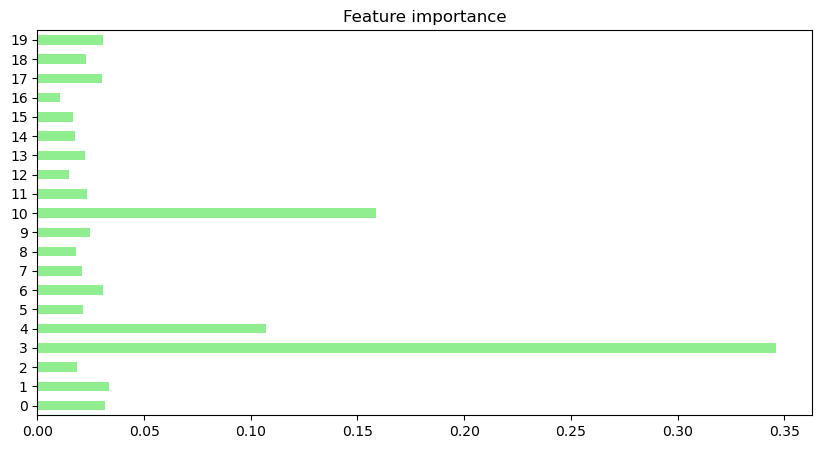

In [50]:
selector = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
selector.fit(X, y)

features = selector.feature_importances_
pd.DataFrame(features).plot(kind='barh', title='Feature importance', legend=False, 
                            figsize=(10,5), color='lightgreen');

In [51]:
features_rfc = np.argsort(features)[::-1][:5] # Select the 5 features with the highest importance
print(f'Features selected by RandomForestClassifier: {features_rfc}')
results['RandomForestClassifier'] = eval_model(X[:,features_rfc], y, LogisticRegression()) + (features_rfc,)

Features selected by RandomForestClassifier: [ 3 10  4  1  0]
Accuracy cv=  5:  0.92 (+/- 0.02)


#### SequentialFeatureSelector

In [52]:
selector = SequentialFeatureSelector(estimator=LogisticRegression(solver = 'saga', penalty= 'l1', max_iter= 500),
                                      n_features_to_select=5, direction='forward')
selector.fit(X, y)
X_sfs = selector.transform(X)
eval_model(X_sfs, y, LogisticRegression())

# Get a boolean mask indicating which features were selected
mask = selector.get_support()

features = np.arange(0,20)[mask]
print(f'Features selected by SequentialFeatureSelector: {features}')
results['SequentialFeatureSelector'] = eval_model(X[:,features], y, LogisticRegression()) + (features,)


Accuracy cv=  5:  0.94 (+/- 0.05)
Features selected by SequentialFeatureSelector: [ 2  3  4 10 11]
Accuracy cv=  5:  0.94 (+/- 0.05)


In [53]:
temp = pd.DataFrame(results, index=['mean acc.','acc. std', 'selected features']).T
temp.sort_values(by='mean acc.', ascending= False).style.format(precision=2).bar(align='mid', subset='mean acc.', color='lightgreen')

,mean acc.,acc. std,selected features
SequentialFeatureSelector,0.94,0.05,[ 2 3 4 10 11]
corr,0.93,0.02,"[3, 4, 10]"
VarianceThreshold,0.93,0.02,[ 3 4 10 17]
RandomForestClassifier,0.92,0.02,[ 3 10 4 1 0]
SelectKBest,0.91,0.04,[ 1 3 4 10 13]
SelectFromModel,0.90,0.05,[0 1 3 4 9]
all features,0.81,0.10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"


We've managed to figure out interesting results.  
Only Sequentual Feature Selector selects feature #2, which wasn't selected by any other method.  

But this conclusion is valid on the specific data set only.  
Changing the random state of `make_classification` will change the data set and the results.  
Changing the random state of `LogisticRegression` will change the results as well.

We need to leverage the power of `GridSearchCV` to find the best combination of feature selection method and model 
and never stop to experiment.
